In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from cycler import K
from common_import import *


def check_config_experiment(whitelist_checkpoint):
    user = getpass.getuser()
    motionbert_root = f'/home/{user}/codes/MotionBERT'
    for checkpoint in whitelist_checkpoint:
        experiment_path = f'{motionbert_root}/experiments/{checkpoint}.txt'
        config_path = f'{motionbert_root}/configs/pose3d/{checkpoint}.yaml'
        print(f'{checkpoint}')
        if os.path.exists(config_path):
            print(f'Config# path: {config_path}')
        else:
            print(f'[No config path] {config_path}')
            with open(config_path, 'w') as f: pass
        if os.path.exists(experiment_path): print(f'Experiment path: {experiment_path}')
        else:
            print(f'[No experiment path] {experiment_path}')
            with open(experiment_path, 'w') as f: pass

# calculate the angle between two forward vectors
def batch_angle_between_vectors(v1_batch, v2_batch, unit="degree"):
    """
    두 3차원 벡터의 배치(batch) 사이 각도를 계산합니다.

    Args:
        v1_batch (ndarray): 첫 번째 벡터의 배치 (shape: [batch_size, 3]).
        v2_batch (ndarray): 두 번째 벡터의 배치 (shape: [batch_size, 3]).
        unit (str): 반환할 각도의 단위 ("radian" 또는 "degree").

    Returns:
        ndarray: 각 벡터 쌍 사이의 각도 배열 (unit에 따라 라디안 또는 도, shape: [batch_size]).
    """
    # 벡터 크기(노름)
    norm_v1 = np.linalg.norm(v1_batch, axis=1)  # shape: [batch_size]
    norm_v2 = np.linalg.norm(v2_batch, axis=1)  # shape: [batch_size]

    # 내적 계산
    dot_product = np.sum(v1_batch * v2_batch, axis=1)  # shape: [batch_size]

    # 코사인 값 계산
    cos_theta = dot_product / (norm_v1 * norm_v2)

    # 부동소수점 오차로 인한 [-1, 1] 범위 클램핑
    cos_theta = np.clip(cos_theta, -1.0, 1.0)

    # 아크 코사인으로 각도 계산 (라디안)
    angles = np.arccos(cos_theta)  # shape: [batch_size]

    # 단위 변환 (degree인 경우)
    if unit == "degree":
        angles = np.degrees(angles)

    return angles

def angle_between_vectors(v1, v2, unit="degree"):
    """
    두 3차원 벡터 사이의 각도를 계산합니다.

    Args:
        v1 (array-like): 첫 번째 벡터 (크기 3).
        v2 (array-like): 두 번째 벡터 (크기 3).

    Returns:
        float: 두 벡터 사이의 각도 (라디안 단위).
    """
    # 벡터를 numpy 배열로 변환
    v1 = np.array(v1)
    v2 = np.array(v2)

    # 벡터의 크기(노름)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)

    # 내적 계산
    dot_product = np.dot(v1, v2)

    # 코사인 값 계산
    cos_theta = dot_product / (norm_v1 * norm_v2)

    # 부동소수점 오차로 인해 cos_theta 값이 [-1, 1] 범위를 약간 벗어날 수 있으므로 클램핑
    cos_theta = np.clip(cos_theta, -1.0, 1.0)

    # 아크 코사인으로 각도 계산 (라디안)
    angle = np.arccos(cos_theta)

    # 단위 변환 (degree인 경우)
    if unit == "degree":
        angle = np.degrees(angle)

    return angle


In [2]:
checkpoint_name = 'MB_train_3dhp_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering'
check_config_experiment([checkpoint_name])

MB_train_3dhp_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering
Config# path: /home/hrai/codes/MotionBERT/configs/pose3d/MB_train_3dhp_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering.yaml
Experiment path: /home/hrai/codes/MotionBERT/experiments/MB_train_3dhp_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering.txt


In [22]:
# load model
args, opts = get_opt_args_from_model_name(checkpoint_name, verbose=False)
subset = 'H36M-GT-CAM_NO_FACTOR-INPUT_FROM_3D_CANONICAL_REVOLUTE-TEST_ALL'
args.subset_list = [subset]
train_loader, test_loader, _, _, datareader = load_dataset(args, use_new_datareader=True)

# load results_all
save_folder = f'/home/hrai/codes/MotionBERT/saved_results/{checkpoint_name}'
if not os.path.exists(save_folder): os.makedirs(save_folder)
save_path = os.path.join(save_folder, f'{subset}.pkl')
results_dict = readpkl(save_path)
results_all = results_dict['results_all']

inputs_all = []
for batch_input, batch_gt in tqdm(test_loader):
    batch_input, batch_gt, batch_gt_torso, batch_gt_limb_pos = preprocess_eval(args, batch_input, batch_gt)
    inputs_all.append(batch_input.cpu().numpy())
inputs_all = np.concatenate(inputs_all)

num_test_frames, action_clips, factor_clips, source_clips, frame_clips, gt_clips, actions = datareader.get_clip_info(args, len(results_all))
action_names = datareader.get_action_list()

Loading dataset...
H36M-GT-CAM_NO_FACTOR-INPUT_FROM_3D_CANONICAL_REVOLUTE-TEST_ALL
[overwrite: False] ==> Loading H36M source_list...
[overwrite: False] ==> Loading H36M cam_param...
[overwrite: False] ==> Loading H36M cam_3d...
[overwrite: False] ==> Loading H36M cam_3d_canonical_revolute...
[overwrite: False] ==> Loading H36M img_2d_canonical_revolute...


100%|██████████| 516/516 [00:02<00:00, 241.60it/s]


In [23]:
inputs_all.shape, results_all.shape

((8244, 243, 17, 3), (8244, 243, 17, 3))

### poses where the angle between pred body frame and gt body frame is larger than 90 degrees

In [6]:
over_90_idxs = []
over_90_inputs = []
over_90_preds = []
over_90_gts = []
over_90_angles = []
forward_vector_preds = []
forward_vector_gts = []

for idx in range(len(results_all)):
    # check if the clip is in the block list
    if 'H36M-SH' in args.subset_list:
        source = source_clips[idx][0][:-6]
    else:
        source = source_clips[idx]
    frame_list = frame_clips[idx] # range(idx*243, (idx+1)*243)
    action = action_clips[idx][0]
    factor = factor_clips[idx][:,None,None]
    input = inputs_all[idx]
    gt = gt_clips[idx]
    pred = results_all[idx]

    pred = pred - pred[:,0:1,:] # (243, 17, 3)
    gt = gt - gt[:,0:1,:] # (243, 17, 3)

    _, pred_lower_frame_R = get_batch_lower_torso_frame_from_pose(pred)
    _, gt_lower_frame_R = get_batch_lower_torso_frame_from_pose(gt)
    forward_vector_pred = pred_lower_frame_R[:, :, 0]
    forward_vector_pred /= torch.norm(forward_vector_pred, dim=1, keepdim=True)
    forward_vector_gt = gt_lower_frame_R[:, :, 0]
    forward_vector_gt /= torch.norm(forward_vector_gt, dim=1, keepdim=True)
    #forward_vector_pred_xz_projected = forward_vector_pred.clone()
    #forward_vector_pred_xz_projected[:, 1] = 0
    #forward_vector_pred_xz_projected /= torch.norm(forward_vector_pred_xz_projected, dim=1, keepdim=True)
    #forward_vector_gt_xz_projected = forward_vector_gt.clone()
    #forward_vector_gt_xz_projected[:, 1] = 0
    #forward_vector_gt_xz_projected /= torch.norm(forward_vector_gt_xz_projected, dim=1, keepdim=True)
    angles = batch_angle_between_vectors(forward_vector_pred.cpu().numpy(), forward_vector_gt.cpu().numpy())

    angle_where_over_90 = np.where(angles > 90)[0]
    if len(angle_where_over_90) > 0:
        #print(angle_where_over_90)
        for i in angle_where_over_90:
            #print(angles[i])
            over_90_idxs.append([idx, i])
            over_90_inputs.append(input[i])
            over_90_preds.append(pred[i])
            over_90_gts.append(gt[i])
            over_90_angles.append(angles[i])
            forward_vector_preds.append(forward_vector_pred[i])
            forward_vector_gts.append(forward_vector_gt[i])
    #break
over_90_inputs = np.stack(over_90_inputs)
over_90_preds = np.stack(over_90_preds)
over_90_gts = np.stack(over_90_gts)
over_90_angles = np.stack(over_90_angles)
forward_vector_preds = np.stack(forward_vector_preds)
forward_vector_gts = np.stack(forward_vector_gts)

In [7]:
over_90_inputs.shape, over_90_preds.shape, over_90_gts.shape, over_90_angles.shape, forward_vector_preds.shape, forward_vector_gts.shape

((7846, 17, 3), (7846, 17, 3), (7846, 17, 3), (7846,), (7846, 3), (7846, 3))

In [8]:
gt_clips[over_90_idxs[frame_num][0]][over_90_idxs[frame_num][1]].shape

NameError: name 'frame_num' is not defined

[898, 164] 101.45681



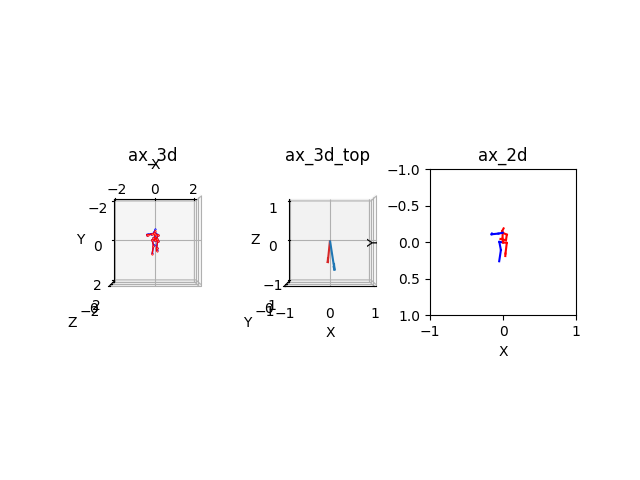

In [9]:
%matplotlib widget
frame_num = 1000
gt = over_90_gts[frame_num]
pred = over_90_preds[frame_num]
input_2d = over_90_inputs[frame_num]
configs = {
    'ax_3d': {'type': '3d', 'loc': 131, 'mode': 'cam'},
    'ax_3d_top': {'type': '3d', 'loc': 132, 'mode': 'cam_top', 'xlim': [-1, 1], 'ylim': [-1, 1], 'zlim': [-1, 1]},
    'ax_2d': {'type': '2d', 'loc': 133, 'normalize': True},
}
fig, axs = generate_axes(0, configs, fig_title='')
plot_pose_setting = [
    #('ax_3d', gt_clips[over_90_idxs[frame_num][0]][over_90_idxs[frame_num][1]],      {'color': 'k', 'label': ''}),
    ('ax_3d', pred,      {'color': 'b', 'label': ''}),
    ('ax_3d', gt,        {'color': 'r', 'label': ''}),
    ('ax_2d', input_2d,  {'color': '', 'label': ''}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
#draw3d_arrow([0, 0, 0], forward_vector_preds[frame_num], head_length=0.2, color="tab:blue", ax = axs['ax_3d'])
#draw3d_arrow([0, 0, 0], forward_vector_gts[frame_num], head_length=0.2, color="tab:red", ax = axs['ax_3d'])
draw3d_arrow([0, 0, 0], forward_vector_preds[frame_num], head_length=0.2, color="tab:blue", ax = axs['ax_3d_top'])
draw3d_arrow([0, 0, 0], forward_vector_gts[frame_num], head_length=0.2, color="tab:red", ax = axs['ax_3d_top'])
print(over_90_idxs[frame_num], over_90_angles[frame_num])
print()
plt.show()

In [10]:
idxs = 898
frame_num = 164
pred = results_all[idxs][frame_num].copy()
gt = gt_clips[idxs][frame_num].copy()
# root-relative
pred = pred - pred[0:1]
gt = gt - gt[0:1]
mpjpe_whole_body = mpjpe_for_each_joint(pred, gt).mean()*1000
print(f'MPJPE whole body: {mpjpe_whole_body:.2f} mm')

def get_part_pose(pose, part='whole'):
    if part == 'whole': return pose
    elif part == 'upper_body': part_keyjoints = get_h36m_keypoint_index(['torso', 'neck', 'nose', 'head', 'l_shoulder', 'l_elbow', 'l_wrist', 'r_shoulder', 'r_elbow', 'r_wrist'])
    elif part == 'lower_body': part_keyjoints = get_h36m_keypoint_index(['pelvis', 'l_hip', 'l_knee', 'l_ankle', 'r_hip', 'r_knee', 'r_ankle'])
    else: raise ValueError(f'Invalid part: {part}')
    if len(pose.shape) == 2: return pose[part_keyjoints]
    elif len(pose.shape) == 3: return pose[:, part_keyjoints]
    else: raise ValueError(f'Invalid pose shape: {pose.shape}')

pred_upper_body = get_part_pose(pred, 'upper_body') # pred[upper_body_joints]
pred_lower_body = get_part_pose(pred, 'lower_body') # pred[lower_body_joints]
gt_upper_body = get_part_pose(gt, 'upper_body') # gt[upper_body_joints]
gt_lower_body = get_part_pose(gt, 'lower_body') # gt[lower_body_joints]

mpjpe_upper_body = mpjpe_for_each_joint(pred_upper_body, gt_upper_body).mean()*1000
mpjpe_lower_body = mpjpe_for_each_joint(pred_lower_body, gt_lower_body).mean()*1000
print(f'MPJPE upper body: {mpjpe_upper_body:.2f}, lower body: {mpjpe_lower_body:.2f} mm')

pred_upper_body_hat = pred_upper_body - pred_upper_body[0:1]
gt_upper_body_hat = gt_upper_body - gt_upper_body[0:1]
mpjpe_upper_body_hat = mpjpe_for_each_joint(pred_upper_body_hat, gt_upper_body_hat).mean()*1000
print(f'MPJPE upper body (root-relative): {mpjpe_upper_body_hat:.2f} mm')

# torso modified pred
def change_torso_position(pred, gt, target_position='gt'):
    pred_upper_body = get_part_pose(pred, 'upper_body')
    pred_upper_body_hat = pred_upper_body - pred_upper_body[0:1]
    torso_idx = get_h36m_keypoint_index(['torso'])
    if len(pred.shape) == 2:
        if target_position == 'gt':
            target_torso = gt[torso_idx].copy()
        elif target_position == 'flip':
            target_torso = pred[torso_idx].copy()
            target_torso[:, 2] *= -1
        pred_upper_body_modified = pred_upper_body_hat.copy() + target_torso
        pred_modified = pred.copy()
        upper_body_joints = get_h36m_keypoint_index(['torso', 'neck', 'nose', 'head', 'l_shoulder', 'l_elbow', 'l_wrist', 'r_shoulder', 'r_elbow', 'r_wrist'])
        pred_modified[upper_body_joints] = pred_upper_body_modified
    elif len(pred.shape) == 3:
        if target_position == 'gt':
            target_torso = gt[:, torso_idx].copy()
        elif target_position == 'flip':
            target_torso = pred[:, torso_idx].copy()
            target_torso[:, :, 2] *= -1
        pred_upper_body_modified = pred_upper_body_hat.copy() + target_torso
        pred_modified = pred.copy()
        upper_body_joints = get_h36m_keypoint_index(['torso', 'neck', 'nose', 'head', 'l_shoulder', 'l_elbow', 'l_wrist', 'r_shoulder', 'r_elbow', 'r_wrist'])
        pred_modified[:, upper_body_joints] = pred_upper_body_modified
    return pred_modified

pred_modified = change_torso_position(pred, gt, target_position='gt')
mpjpe_whole_body_modified = mpjpe_for_each_joint(pred_modified, gt).mean()*1000
print(f'MPJPE whole body (torso modified by gt torso): {mpjpe_whole_body_modified:.2f} mm')

pred_modified_zflipped = change_torso_position(pred, gt, target_position='flip')
mpjpe_whole_body_modified_zflipped = mpjpe_for_each_joint(pred_modified_zflipped, gt).mean()*1000
print(f'MPJPE whole body (torso modified by z-filpped pred torso): {mpjpe_whole_body_modified_zflipped:.2f} mm')

MPJPE whole body: 274.02 mm
MPJPE upper body: 422.43, lower body: 62.00 mm
MPJPE upper body (root-relative): 84.54 mm
MPJPE whole body (torso modified by gt torso): 75.26 mm
MPJPE whole body (torso modified by z-filpped pred torso): 101.08 mm


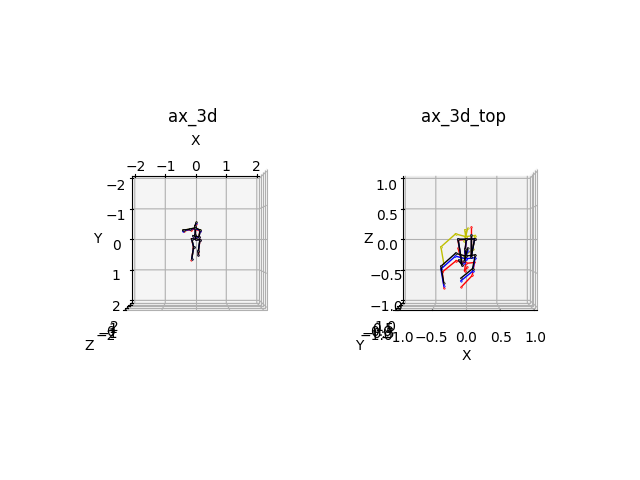

In [11]:
%matplotlib widget
configs = {
    'ax_3d': {'type': '3d', 'loc': 121, 'mode': 'cam'},
    'ax_3d_top': {'type': '3d', 'loc': 122, 'mode': 'cam_top', 'xlim': [-1, 1], 'ylim': [-1, 1], 'zlim': [-1, 1]},
}
fig, axs = generate_axes(1, configs, fig_title='')
plot_pose_setting = [
    ('ax_3d', gt,                       {'color': 'r', 'label': ''}),
    ('ax_3d', pred,                     {'color': 'y', 'label': ''}),
    ('ax_3d', pred_modified,        {'color': 'b', 'label': ''}),
    ('ax_3d', pred_modified_zflipped, {'color': 'k', 'label': ''}),
    ('ax_3d_top', gt,               {'color': 'r', 'label': ''}),
    ('ax_3d_top', pred,             {'color': 'y', 'label': ''}),
    ('ax_3d_top', pred_modified,    {'color': 'b', 'label': ''}),
    ('ax_3d_top', pred_modified_zflipped, {'color': 'k', 'label': ''}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

### poses that have large error than mean

In [28]:
err1_per_frames = []
for idx in range(len(results_all)):
    # check if the clip is in the block list
    if 'H36M-SH' in args.subset_list:
        source = source_clips[idx][0][:-6]
    else:
        source = source_clips[idx]
    frame_list = frame_clips[idx] # range(idx*243, (idx+1)*243)
    action = action_clips[idx][0]
    factor = factor_clips[idx][:,None,None]
    input = inputs_all[idx]
    gt = gt_clips[idx]
    pred = results_all[idx]

    pred = pred - pred[:,0:1,:] # (243, 17, 3)
    gt = gt - gt[:,0:1,:] # (243, 17, 3)

    err1_per_joint = mpjpe_for_each_joint(pred, gt) # (243, 17)
    err1_per_frame = np.mean(err1_per_joint, axis=1) # mpjpe(pred, gt) # (243, )
    err1_per_frames.append(err1_per_frame)

    #err2_per_joint = p_mpjpe_for_each_joint(pred, gt) # (243, 17)
    #err2 = np.mean(err2_per_joint, axis=1) # p_mpjpe(pred, gt) # (243, )

err1_per_frames = np.stack(err1_per_frames)
print(f"Minimum error: {err1_per_frames.min()*1000:.2f} mm")
print(f"Maximum error: {err1_per_frames.max()*1000:.2f} mm")
print(f"Mean error: {err1_per_frames.mean()*1000:.2f} mm")
print(f"Median error: {np.median(err1_per_frames)*1000:.2f} mm")

Minimum error: 18.09 mm
Maximum error: 681.57 mm
Mean error: 82.13 mm
Median error: 73.79 mm


18.090481192999476
681.5675157567334


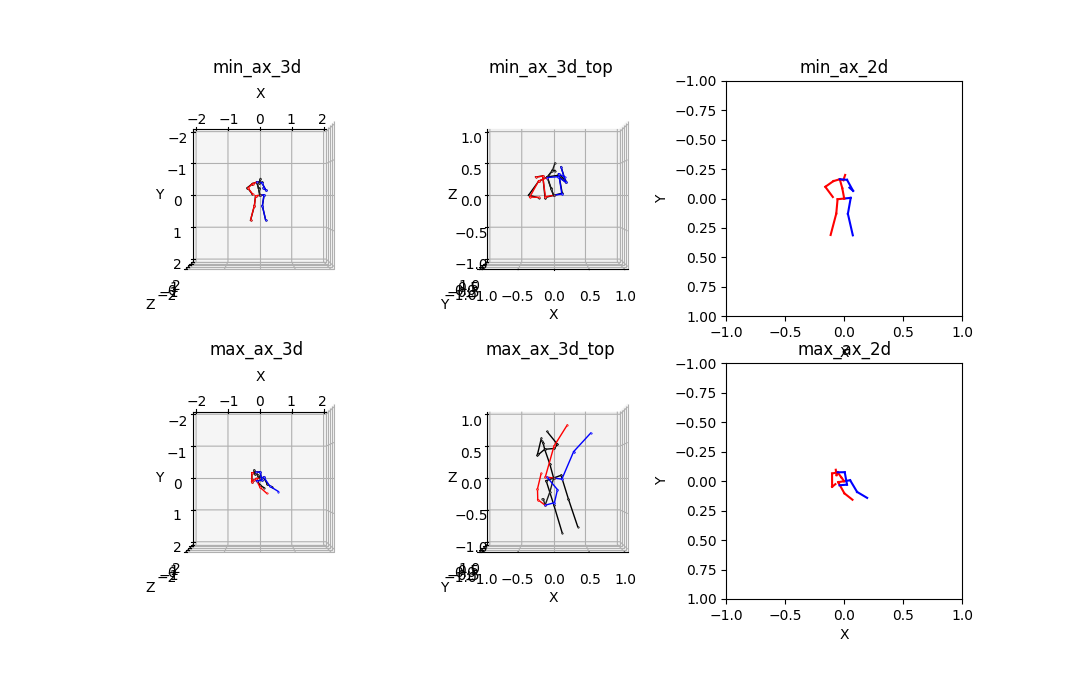

In [74]:
%matplotlib widget
min_frame_num = np.argmin(err1_per_frames) % 243
min_idx = np.argmin(err1_per_frames) // 243
min_gt = gt_clips[min_idx][min_frame_num].copy()
min_gt -= min_gt[0]
min_pred = results_all[min_idx][min_frame_num].copy()
min_pred -= min_pred[0]

max_frame_num = np.argmax(err1_per_frames) % 243
max_idx = np.argmax(err1_per_frames) // 243
max_gt = gt_clips[max_idx][max_frame_num].copy()
max_gt -= max_gt[0]
max_pred = results_all[max_idx][max_frame_num].copy()
max_pred -= max_pred[0]

print(mpjpe_for_each_joint(min_pred, min_gt).mean()*1000)
print(mpjpe_for_each_joint(max_pred, max_gt).mean()*1000)
configs = {
    'min_ax_3d': {'type': '3d', 'loc': 231, 'mode': 'cam'},
    'min_ax_3d_top': {'type': '3d', 'loc': 232, 'mode': 'cam_top', 'xlim': [-1, 1], 'ylim': [-1, 1], 'zlim': [-1, 1]},
    'min_ax_2d': {'type': '2d', 'loc': 233, 'normalize': True},
    'max_ax_3d': {'type': '3d', 'loc': 234, 'mode': 'cam'},
    'max_ax_3d_top': {'type': '3d', 'loc': 235, 'mode': 'cam_top', 'xlim': [-1, 1], 'ylim': [-1, 1], 'zlim': [-1, 1]},
    'max_ax_2d': {'type': '2d', 'loc': 236, 'normalize': True},
}
fig, axs = generate_axes(2, configs, fig_title='')
plot_pose_setting = [
    ('min_ax_3d', min_gt,                               {'color': 'k', 'label': ''}),
    ('min_ax_3d', min_pred,                             {'color': '', 'label': ''}),
    ('min_ax_3d_top', min_gt,                           {'color': 'k', 'label': ''}),
    ('min_ax_3d_top', min_pred,                         {'color': '', 'label': ''}),
    ('min_ax_2d', inputs_all[min_idx][min_frame_num],   {'color': '', 'label': ''}),
    ('max_ax_3d', max_gt,                               {'color': 'k', 'label': ''}),
    ('max_ax_3d', max_pred,                             {'color': '', 'label': ''}),
    ('max_ax_3d_top', max_gt,                           {'color': 'k', 'label': ''}),
    ('max_ax_3d_top', max_pred,                         {'color': '', 'label': ''}),
    ('max_ax_2d', inputs_all[max_idx][max_frame_num],   {'color': '', 'label': ''}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

In [66]:
max_pred.shape

(243, 17, 3)

### z-axis reverse

In [27]:
err1_per_frames = []
for idx in range(len(results_all)):
    # check if the clip is in the block list
    if 'H36M-SH' in args.subset_list:
        source = source_clips[idx][0][:-6]
    else:
        source = source_clips[idx]
    frame_list = frame_clips[idx] # range(idx*243, (idx+1)*243)
    action = action_clips[idx][0]
    factor = factor_clips[idx][:,None,None]
    input = inputs_all[idx]
    gt = gt_clips[idx]
    pred = results_all[idx]

    pred = pred - pred[:,0:1,:] # (243, 17, 3)
    gt = gt - gt[:,0:1,:] # (243, 17, 3)

    err1_per_joint = mpjpe_for_each_joint(pred, gt) # (243, 17)
    err1_per_frame = np.mean(err1_per_joint, axis=1) # mpjpe(pred, gt) # (243, )

    # z-axis flip
    pred_zflip = pred.copy()
    pred_zflip[:, :, 2] *= -1
    err1_per_joint_zflip = mpjpe_for_each_joint(pred_zflip, gt)
    err1_per_frame_zflip = np.mean(err1_per_joint_zflip, axis=1)

    for i in range(len(err1_per_frame)):
        if err1_per_frame[i] > err1_per_frame_zflip[i]:
            err1_per_frame[i] = err1_per_frame_zflip[i]
    err1_per_frames.append(err1_per_frame)

err1_per_frames = np.stack(err1_per_frames)
print(f"Minimum error: {err1_per_frames.min()*1000:.2f} mm")
print(f"Maximum error: {err1_per_frames.max()*1000:.2f} mm")
print(f"Mean error: {err1_per_frames.mean()*1000:.2f} mm")
print(f"Median error: {np.median(err1_per_frames)*1000:.2f} mm")

Minimum error: 18.09 mm
Maximum error: 402.12 mm
Mean error: 81.12 mm
Median error: 73.79 mm


In [26]:
err1_per_frames = []
for idx in range(len(results_all)):
    # check if the clip is in the block list
    if 'H36M-SH' in args.subset_list:
        source = source_clips[idx][0][:-6]
    else:
        source = source_clips[idx]
    frame_list = frame_clips[idx] # range(idx*243, (idx+1)*243)
    action = action_clips[idx][0]
    factor = factor_clips[idx][:,None,None]
    input = inputs_all[idx]
    gt = gt_clips[idx]
    pred = results_all[idx]

    pred = pred - pred[:,0:1,:] # (243, 17, 3)
    gt = gt - gt[:,0:1,:] # (243, 17, 3)

    err1_per_joint = mpjpe_for_each_joint(pred, gt) # (243, 17)
    err1_per_frame = np.mean(err1_per_joint, axis=1) # mpjpe(pred, gt) # (243, )

    # z-axis flip
    pred_zflip = pred.copy()
    pred_zflip[:, :, 2] *= -1
    err1_per_joint_zflip = mpjpe_for_each_joint(pred_zflip, gt)
    for frame in range(243):
        for joint in range(17):
            if err1_per_joint[frame, joint] > err1_per_joint_zflip[frame, joint]:
                err1_per_joint[frame, joint] = err1_per_joint_zflip[frame, joint]
    err1_per_frame = np.mean(err1_per_joint, axis=1)
    err1_per_frames.append(err1_per_frame)

err1_per_frames = np.stack(err1_per_frames)
print(f"Minimum error: {err1_per_frames.min()*1000:.2f} mm")
print(f"Maximum error: {err1_per_frames.max()*1000:.2f} mm")
print(f"Mean error: {err1_per_frames.mean()*1000:.2f} mm")
print(f"Median error: {np.median(err1_per_frames)*1000:.2f} mm")

Minimum error: 17.24 mm
Maximum error: 315.51 mm
Mean error: 67.25 mm
Median error: 63.83 mm


In [25]:
err1_per_frames = []
for idx in range(len(results_all)):
    # check if the clip is in the block list
    if 'H36M-SH' in args.subset_list:
        source = source_clips[idx][0][:-6]
    else:
        source = source_clips[idx]
    frame_list = frame_clips[idx] # range(idx*243, (idx+1)*243)
    action = action_clips[idx][0]
    factor = factor_clips[idx][:,None,None]
    input = inputs_all[idx]
    gt = gt_clips[idx]
    pred = results_all[idx]

    pred = pred - pred[:,0:1,:] # (243, 17, 3)
    gt = gt - gt[:,0:1,:] # (243, 17, 3)

    err1_per_joint = mpjpe_for_each_joint(pred, gt) # (243, 17)
    err1_per_frame = np.mean(err1_per_joint, axis=1) # mpjpe(pred, gt) # (243, )

    pred_modified = change_torso_position(pred, gt, target_position='gt')
    #print(preds_modified.shape)
    err1_per_joint_modified = mpjpe_for_each_joint(pred_modified, gt)
    err1_per_frame_modified = np.mean(err1_per_joint_modified, axis=1)

    for frame in range(243):
        if err1_per_frame[frame] > err1_per_frame_modified[frame]:
            #print(f'frame: {frame}, {err1_per_frame[frame]*1000:.2f} -> {err1_per_frame_modified[frame]*1000:.2f}')
            #err1_per_frame[frame] = err1_per_frame_modified[frame]
            err1_per_frames.append(err1_per_frame_modified[frame])
        else:
            err1_per_frames.append(err1_per_frame[frame])

err1_per_frames = np.stack(err1_per_frames)
print(f"Minimum error: {err1_per_frames.min()*1000:.2f} mm")
print(f"Maximum error: {err1_per_frames.max()*1000:.2f} mm")
print(f"Mean error: {err1_per_frames.mean()*1000:.2f} mm")
print(f"Median error: {np.median(err1_per_frames)*1000:.2f} mm")

Minimum error: 18.09 mm
Maximum error: 552.56 mm
Mean error: 81.79 mm
Median error: 73.79 mm


In [18]:
err1_per_joint_modified.shape

(243, 17)